In [1]:
## Initial setup.

# Import all modules:
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Set plot parameters:
clr = 'black'  # Colour to be used for text
plotclr = 'tab:orange'
params = {'font.family' : 'Arial',
          'font.size' : 16,
          'axes.titlepad' : 10,
          'axes.labelcolor' : clr,
          'axes.edgecolor' : clr,
          'ytick.color' : clr,
          'xtick.color' : clr,
         }
plt.rcParams.update(params)

In [2]:
## Define all values to be used.

# Constants:
Delta = 0  # Detuning
Gamma = 1  # Decay rate
Omega = 10 * Gamma  # Rabi frequency
n = 1000  # Number of time steps
N = 1000  # Number of runs

# System state:
a = 0
b = 1
psi = np.array([a, b])  # Qubit state
psi_0 = np.array([1, 0])  # Ground state
psi_1 = np.array([0, 1])  # Excited state
psi_evol = np.zeros((n + 1, 2))  # Array of qubit's evolution for n time steps

# Time steps:
dt = 0.01 * Gamma
t = np.zeros(n + 1)  # Array of timestamps to loop over
for i in range(1, n + 1):
    t[i] = i * dt
    
# Matrices:
I = np.array([[1, 0], [0, 1]])  # Identity matrix
H = 0.5 * np.array([[Delta, Omega], [Omega, -Delta]])  # Hamiltonian (Hermitian)
H_eff = H - 0.5 * np.array([[0, 0], [0, 1j*Gamma]])  # Effective Hamiltonian (non-Hermitian)
H_tot = I - 1j * H_eff * dt  # Combined Hamiltonian to be used in MCW

In [3]:
## Define all methods and functions.

# Solve OBEs:
def solve(t):
    # Split into five terms (A-E) for simplicity.
    A = Omega ** 2 / (2 * Omega ** 2 + Gamma ** 2)
    B = np.exp(-(3 * Gamma * t) / 4)
    C = np.cos(np.sqrt(Omega ** 2 - (Gamma ** 2) / 16) * t)
    D = 3 * Gamma / np.sqrt(16 * Omega ** 2 - Gamma ** 2)
    E = np.sin(np.sqrt(Omega ** 2 - (Gamma ** 2) / 16) * t)
    return A * (1 - B * (C + D * E))

# Renormalise wavefunction:
def renorm(psi, mag_sq):  # Parameters are wavefunction and SQUARED magnitude
    return psi / np.sqrt(mag_sq)

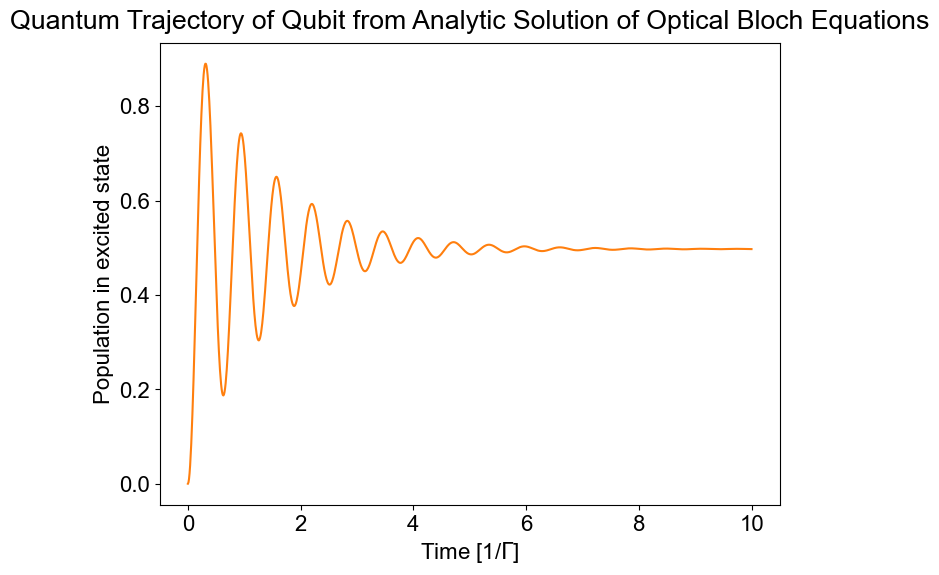

In [4]:
## Analytic solution to OBEs.

# Create empty array:
arr = np.empty(n+1)

# Solve equations and plot solution n times:
for i in range(n+1):
    arr[i] = solve(t[i])

plt.figure(figsize=(8, 6))  
plt.plot(t, arr, color=plotclr)
plt.title('Quantum Trajectory of Qubit from Analytic Solution of Optical Bloch Equations', color=clr)
plt.xlabel('Time [1/{}]'.format(r'$\Gamma$'))
plt.ylabel('Population in excited state')

plt.savefig('Analytic.png', transparent=True, bbox_inches='tight')
plt.show()

In [5]:
## Simulation of MCW using a small time step.

P = np.empty((N, n + 1))

for i in range(N):
    
    # Initialise in ground state:
    test = psi_0
    b_pop = [0]
    
    for j in range(n):

        test = np.matmul(H_tot, test)
        
        mag = abs(test[0] ** 2) + abs(test[1] ** 2)
        r = random.random()

        if r > mag:
            test = np.array([1, 0])
        else:
            term_0 = 0.5 * Gamma * dt * test[1] ** 2
            term_1 = 0.5 * Gamma * dt * test[0] ** 2
            
            test[0] = test[0] * (1 + term_0)
            test[1] = test[1] * (1 - term_1)
            
            test = test / np.sqrt(mag)  # Renormalisation
        
        b_pop += [abs(test[1]) ** 2]  # Assign to nth element of array
        
    P[i] = b_pop  # Assign array to Nth row of matrix

P_one = P[10]  # Set aside one quantum trajectory before averaging
P = P.mean(axis=0)  # Average trajectories over N atoms

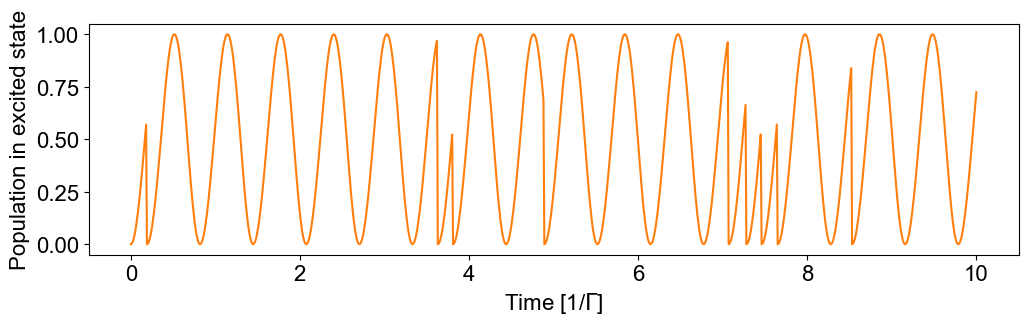

In [6]:
## Plot of a single quantum trajectory.

plt.figure(figsize=(12, 3))
plt.plot(t, P_one, color=plotclr)
# plt.title('Single Quantum Trajectory', color=clr)
plt.xlabel('Time [1/{}]'.format(r'$\Gamma$'), color=clr)
plt.ylabel('Population in excited state')

plt.savefig('SingleTrajectory.png', transparent=True, bbox_inches='tight')
plt.show()

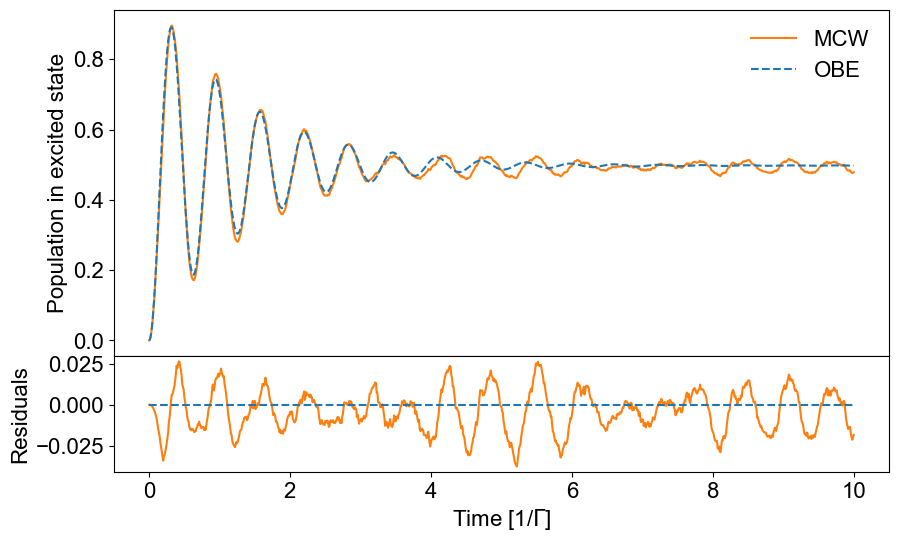

In [8]:
## Plot to compare MCW with OBEs:

# Calculate residuals:
residuals = np.zeros(n+1)
for i in range(n+1):
    residuals[i] = P[i] - arr[i]
    
# Generate figure:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

# Plot quantum trajectory (on axes 0) and residuals (on axes 1):
ax0.plot(t, P, label='MCW', color=plotclr)
ax0.plot(t, arr, label='OBE', linestyle='--')
ax1.plot(t, residuals, color=plotclr)
ax1.plot([0, 10], [0, 0], linestyle='--')

# ax0.set_title('Quantum Trajectory of Qubit for N = 1000 Atoms', color=clr)
ax1.set_xlabel('Time [1/{}]'.format(r'$\Gamma$'))
ax1.set_ylabel('Residuals')
ax0.set_ylabel('Population in excited state')

ax0.legend(labelcolor=clr, framealpha=0)

plt.savefig('Comparison.png', transparent=True, bbox_inches='tight')
plt.show()